# Generating spikes from oscillatory instantaneous rate profiles

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from synchrony import ISI

## spike trains parameters

In [3]:
# time parameters
T = 1000 # in ms
dt = 0.001

# neuron number
N = 10

# baseline firing rate (spk per second)
r0 = 30.0

# correlation parameters
rc = 8.0 # rate of correlated event : pour chaque time on veut 8 spike simultanés ? 
p = 0.3 # probability of firing for neurons in pattern : prob de décharger en même temps sachant le taux de décharge ? 
nrn_pat = range(5) # neurons in pattern

# instantaneous firing rates
inst_rate = np.ones([N,T]) * r0 
for i in nrn_pat:
    # reduce baseline firing rate for pattern neurons (to match others) : pourquoi ? 
    inst_rate[i] -= rc * p
corr_event_rate = np.ones([T]) * rc 

## generate spike train

In [4]:
spk_ts = []
for i in range(N):
    # non correlated spikes
    spk_ts += [list(np.argwhere(np.random.rand(T)<inst_rate[i,:]*dt).flatten())] # pourquoi : inst_rate[i,:]*dt ? 
                                                                                 # sachant taux de décharge instant la proba de spike doit etre plus grande que celle
                                                                                 # obtenue aléatoirement

# correlated events
ev = np.argwhere(np.random.rand(T)<corr_event_rate*dt).flatten()

for t in ev.flatten(): # pourquoi .flatten
    # add a spike to each neuron involved in the pattern with probability p
    for i in nrn_pat:
        if np.random.rand()<p:
            spk_ts[i].append(t)
# resort spike times and format as array
for i in range(N):
    spk_ts[i] = np.array(np.sort(spk_ts[i]))



### spike raster

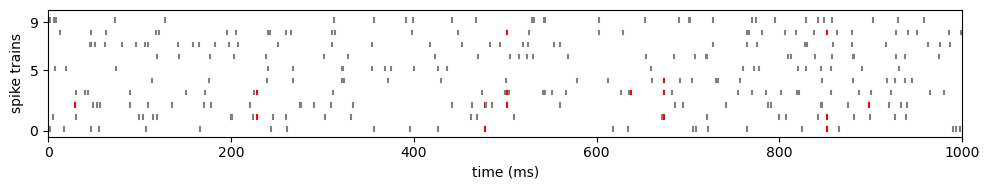

In [5]:
frmt_grph = 'png'
cols = ['r','gray']

plt.figure(figsize=[10,2])
for i in range(N):
    for t in spk_ts[i]:
        if t in ev:
            plt.plot((t,t), (i,i+0.3), c=cols[0], lw=1.5)
        else:
            plt.plot((t,t), (i,i+0.3), c=cols[1], lw=1.5)
plt.yticks([0,5,9])
plt.axis(xmin=0, xmax=T, ymin=-0.5, ymax=N)
plt.xlabel('time (ms)')
plt.ylabel('spike trains')
plt.tight_layout()

In [6]:
def compute(x, T):
    n_times = T
    x_isi_in_time = np.zeros(n_times)

    # Utiliser les valeurs d'`x['spike_time']` comme indices de début et de fin pour chaque intervalle entre les spikes
    start_indices = x[:-1]
    end_indices = x[1:]

    # Mettre à True les indices entre chaque paire d'indices dans mask
    for start, end in zip(start_indices, end_indices):
        x_isi_in_time[start:end] = np.repeat(end-start, end-start)

    return x_isi_in_time

def distance(x_isi, y_isi):
    ISI_distance = np.zeros_like(x_isi)
    ISI_distance[np.logical_and(x_isi==0, y_isi>0)] = -1 
    ISI_distance[np.logical_and(x_isi>0, y_isi==0)] = 1 

    # indices where x_isi is smaller than y_isi 
    idx_xsy = x_isi < y_isi
    ISI_distance[idx_xsy] =  (x_isi[idx_xsy] / y_isi[idx_xsy]) - 1

    # indices where y_isi is smaller than x_isi 
    idx_ysx = y_isi < x_isi
    ISI_distance[idx_ysx] = -((y_isi[idx_ysx] / x_isi[idx_ysx]) - 1)

    return ISI_distance

In [7]:
x = 0
y = 3
x_isi_in_time = compute(spk_ts[x], T)
y_isi_in_time = compute(spk_ts[y], T)
ISI_distance = ISI.distance(x_isi_in_time, y_isi_in_time)

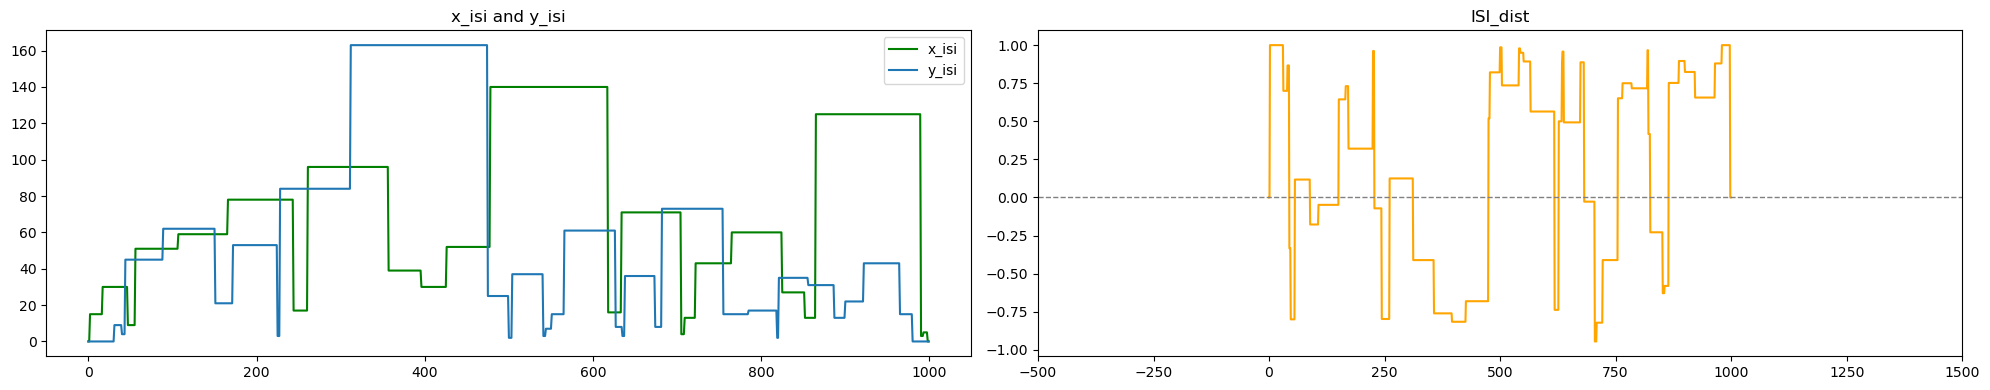

In [8]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
# Plot x_isi and y_isi in the first column
axs[0].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[0].plot(y_isi_in_time, label='y_isi')
axs[0].set_title('x_isi and y_isi')
axs[0].legend()

# Plot isi_dist in the second column
axs[1].plot(ISI_distance, color='orange')
axs[1].set_title('ISI_dist')
axs[1].hlines(0, xmin=-500, xmax=ISI_distance.shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[1].set_xlim(-500, ISI_distance.shape[0] + 500)  # Set x-axis limits

plt.tight_layout()